Lautaro Silva

Carrera: Lic. en Ciencias Fisicas

DNI: 43441919

LU: 879/21

Email: lautarosilvapizzi@gmail.com

# Exercise!

Consider the equation

$$x^{\prime\prime}(t)+\alpha x^{\prime}(t)-\beta x(t)=0$$

with initial conditions: $x(0)=1$, $x^\prime(0)=0$, and $t \in [0,1]$.

**a)** Solve the equation using the `neurodiffeq` module for the values $\alpha = \beta = 1$. Note: you CAN'T fix $\beta=0$ and use the bundle method only for $\alpha$.

**b)** Compute the percentage difference between the PINN-based solution and the analytical one in the range $[0,1]$. Now do the same for the range $[-1,2]$. 

**Hint:** The analytical solution for these parameter values is:

$$x(t) = \frac{1}{2\sqrt{5}}\left((1+\sqrt{5})e^{(-1+\sqrt{5})t/2}+(-1+\sqrt{5})e^{-(1+\sqrt{5})t/2}\right)$$

**c)** Achieve an accuracy such that the percentage error is less than 1% for all values of t (if your solution is not so good, go back to training!).

**d)** Compute and plot the residuals and try to interpretate them.

Send your solution to gomezlucajavier@gmail.com.

**Note:** You can solve this exercise with or without using the *bundle method*. If you choose to use the bundle method, be careful with the number of inputs to the networks, and also with the definition of `eq_param_index` in the solver. While the bundle method might make it easier to follow the structure of the code, it may also lead to longer training times.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
from neurodiffeq import diff
from neurodiffeq.networks import FCNN
from neurodiffeq.generators import Generator1D
from neurodiffeq.conditions import BundleIVP
from neurodiffeq.solvers import BundleSolver1D
from sklearn.metrics import mean_absolute_error
import time

In [2]:
print(torch.cuda.is_available())

print(torch.__version__)
print(torch.version.cuda)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using: ", device)

torch.cuda.empty_cache()

True
2.7.1+cu118
11.8
Using:  cuda


In [3]:
# Tiempos para ambos rangos
t_0_i, t_f_i = 0.0, 1.0
t_0_ii, t_f_ii = -1.0, 2.0

# Rangos de parametros para alpha y beta (los hago cerca de lo deseado para ahorrar costo computaciona;)
alpha_0, alpha_f = 0.9, 1.1
beta_0, beta_f = 0.9, 1.1

# Condiciones Iniciales
x0, x0_dot = 1.0, 0.0
conds = [BundleIVP(t_0_i, x0), BundleIVP(t_0_i, x0_dot)]

def ODE(x, x_p, t, alpha, beta):
    res1 = diff(x, t) - x_p
    res2 = diff(x_p, t) + alpha * x_p - beta * x
    return [res1, res2]

def loss(res, x, t):
    return (res ** 2).mean()

nets = [FCNN(n_input_units=3, hidden_units=(32,32,)) for _ in range(2)] # 3 inputs (t, alpha, beta)
adam = torch.optim.Adam(set([p for net in nets for p in net.parameters()]), lr=1e-3)

batch_size = 5
tg_t = Generator1D(batch_size, t_min=t_0_i, t_max=t_f_i)
vg_t = Generator1D(batch_size, t_min=t_0_i, t_max=t_f_i)

tg_alpha = Generator1D(batch_size, t_min=alpha_0, t_max=alpha_f)
vg_alpha = Generator1D(batch_size, t_min=alpha_0, t_max=alpha_f)

tg_beta = Generator1D(batch_size, t_min=beta_0, t_max=beta_f)
vg_beta = Generator1D(batch_size, t_min=beta_0, t_max=beta_f)

train_gen = tg_t ^ tg_alpha ^ tg_beta
valid_gen = vg_t ^ vg_alpha ^ vg_beta

In [4]:
solver = BundleSolver1D(
    ode_system=ODE,
    conditions=conds,
    t_min=t_0_i, t_max=t_f_i,
    theta_min=(alpha_0, beta_0),
    theta_max=(alpha_f, beta_f),
    eq_param_index=(0, 1),
    nets=nets,
    train_generator=train_gen,
    valid_generator=valid_gen,
    optimizer=adam,
    loss_fn=loss,
)

In [5]:
# Entrenamiento
start_time = time.time()
solver.fit(max_epochs=5000)
end_time = time.time()
elapsed = end_time - start_time
print(f"Tiempo de entrenamiento: {elapsed:.2f} segundos")

Training Progress:   0%|                                                                      | 0/5000 [00:00<…

Tiempo de entrenamiento: 116.35 segundos


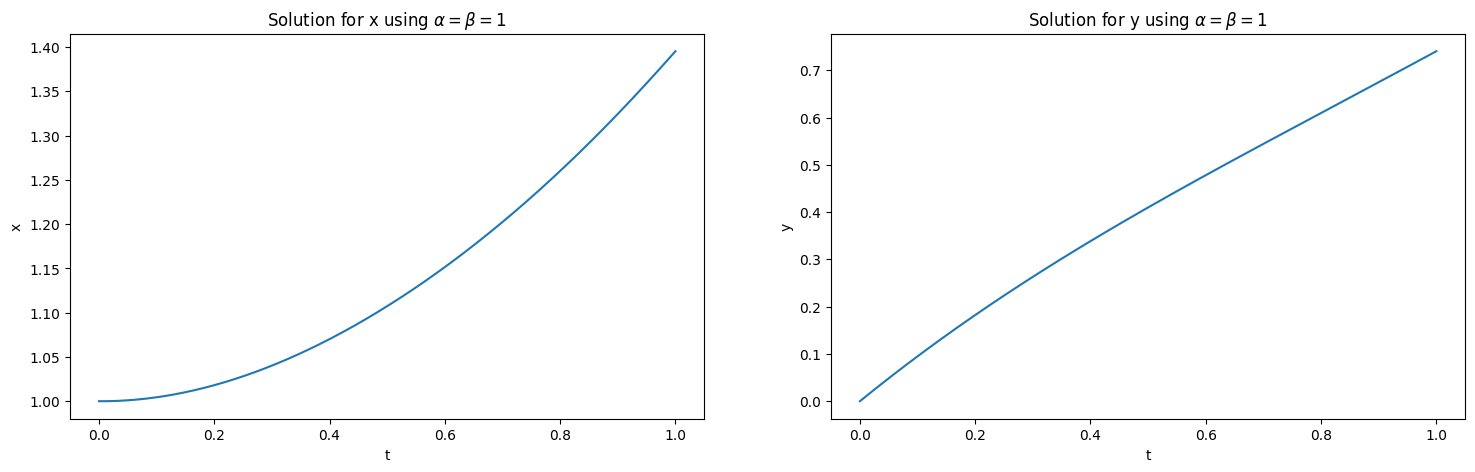

In [6]:
v_sol = solver.get_solution()
t = np.linspace(t_0_i, t_f_i, 1000)
alpha = 1
alphas = alpha * np.ones_like(t)
beta = 1
betas = beta * np.ones_like(t)
x, y = v_sol(t, alphas, betas, to_numpy=True)


fig, ax = plt.subplots(1, 2, figsize=(18,5))
ax[0].plot(t, x)
ax[0].set_xlabel('t')
ax[0].set_ylabel('x')
ax[0].set_title(r'Solution for x using $\alpha = \beta = 1$')
ax[1].plot(t, y)
ax[1].set_xlabel('t')
ax[1].set_ylabel('y')
ax[1].set_title(r'Solution for y using $\alpha = \beta = 1$')
plt.show()

C:\Users\Usuario\AppData\Local\Temp\ipykernel_18224\1375856155.py:20: RuntimeWarning: invalid value encountered in divide
  perc_err_y = 100 * np.abs(y - y_exact)/np.abs(y_exact)


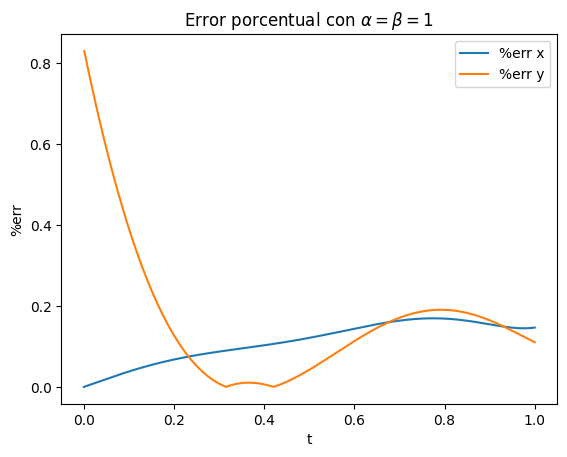

In [7]:
# Solucion Analitica para x(t)
def sol_exacta(t):
    primer_termino = (1 + np.sqrt(5)) * np.exp((-1 + np.sqrt(5)) * t / 2)
    segundo_termino = (-1 + np.sqrt(5)) * np.exp((-1 - np.sqrt(5)) * t / 2)
    return (1 / (2 * np.sqrt(5))) * (primer_termino + segundo_termino)

x_exact = sol_exacta(t)

# Solucion Analitica para x'(t)
def sol_exacta_derivada(t):
    der_1 = (-1 + np.sqrt(5)) / 2
    der_2 = (-1 - np.sqrt(5)) / 2
    primer_termino = (1 + np.sqrt(5)) * der_1 * np.exp(der_1 * t)
    segundo_termino = (-1 + np.sqrt(5)) * der_2 * np.exp(der_2 * t)
    return (1 / (2 * np.sqrt(5))) * (primer_termino + segundo_termino)

y_exact = sol_exacta_derivada(t)

perc_err_x = 100 * np.abs(x - x_exact)/np.abs(x_exact)
perc_err_y = 100 * np.abs(y - y_exact)/np.abs(y_exact)

plt.figure()
plt.plot(t, perc_err_x, label = '%err x')
plt.plot(t, perc_err_y, label = '%err y')
plt.xlabel('t')
plt.ylabel('%err')
plt.title(r'Error porcentual con $\alpha = \beta= 1$')
plt.legend()
plt.show()

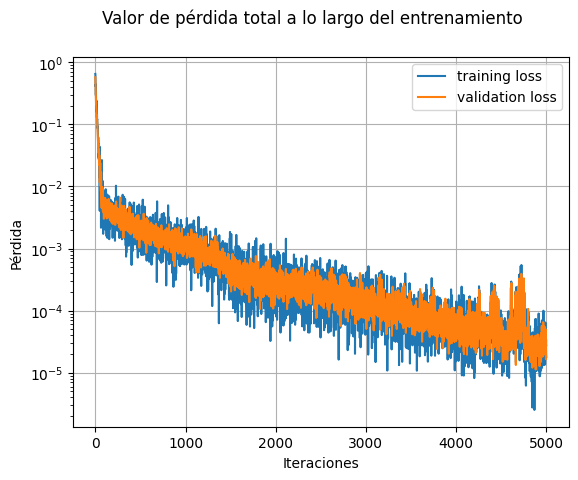

In [8]:
plt.figure()
perdida_train = solver.metrics_history['train_loss']
perdida_valid = solver.metrics_history['valid_loss']
plt.plot(perdida_train, label='training loss')
plt.plot(perdida_valid, label='validation loss')
plt.xlabel('Iteraciones')
plt.ylabel('Pérdida')
plt.yscale('log')
plt.grid()
plt.legend()
plt.suptitle('Valor de pérdida total a lo largo del entrenamiento')
plt.show()

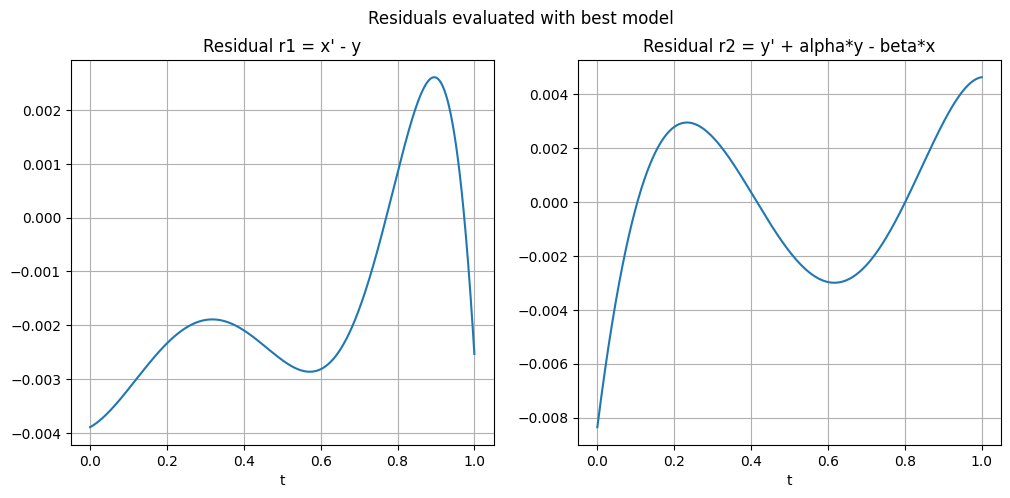

In [9]:
# Llamá a get_residuals con numpy arrays y que te devuelva numpy
residuals = solver.get_residuals(t, alphas, betas, to_numpy=True)

# residuals es una lista con residuos para cada ecuación (r1 y r2)
r1 = residuals[0]
r2 = residuals[1]

# Graficar
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(t, r1)
plt.title('Residual r1 = x\' - y')
plt.xlabel('t')
plt.grid()

plt.subplot(1,2,2)
plt.plot(t, r2)
plt.title('Residual r2 = y\' + alpha*y - beta*x')
plt.xlabel('t')
plt.grid()

plt.suptitle('Residuals evaluated with best model')
plt.show()


Cosas interesantes a las que llegue haciendo prueba y error con este notebook. En primer lugar, correrlo en la GPU de mi compu de escritorio (Nvidia 1650) es el doble de rapido (tarda la mitad en entrenar). En segundo lugar, el parmetro con el que mas jugue y el que llegue a la conclusion que mas importa es le batch_size. No me termina de quedar claro porque es asi, pero me sucedia que si hacia lo que me hubiera imaginado que era mejor, que es usar muchos datos iniciales, el modelo iba peor (no hablando del tiempo de computo sino la performance del error). Por otro lado, trate de juagr un poco tambien con la cantidad de capas y neuronas por capa, pero usando la propuesta en el tutorial de 2x32 anduvo perfecto. Se ve que la loss es suave y podria serguir mejorando, lo que es bueno e indica que el error tambien podria disminuir. Tratando de ver los residuos, se ve que los valroes son verdaderamente marginales para todos los tiempos a analizar lo que indica un buen fiteo.

### Otro set de parametros temporales

In [31]:
nets = [FCNN(n_input_units=3, hidden_units=(64,64,32,)) for _ in range(3)] # 3 inputs (t, alpha, beta)
adam = torch.optim.Adam(set([p for net in nets for p in net.parameters()]), lr=1e-3)

batch_size = 32
tg_t_ii = Generator1D(batch_size, t_min=t_0_ii, t_max=t_f_ii)
vg_t_ii = Generator1D(batch_size, t_min=t_0_ii, t_max=t_f_ii)

tg_alpha = Generator1D(batch_size, t_min=alpha_0, t_max=alpha_f)
vg_alpha = Generator1D(batch_size, t_min=alpha_0, t_max=alpha_f)

tg_beta = Generator1D(batch_size, t_min=beta_0, t_max=beta_f)
vg_beta = Generator1D(batch_size, t_min=beta_0, t_max=beta_f)

train_gen_ii = tg_t_ii ^ tg_alpha ^ tg_beta
valid_gen_ii = vg_t_ii ^ vg_alpha ^ vg_beta

In [32]:
solver_ii = BundleSolver1D(
    ode_system=ODE,
    conditions=conds,
    t_min=t_0_ii, t_max=t_f_ii,
    theta_min=(alpha_0, beta_0),
    theta_max=(alpha_f, beta_f),
    eq_param_index=(0, 1),
    nets=nets,
    train_generator=train_gen_ii,
    valid_generator=valid_gen_ii,
    optimizer=adam,
    loss_fn=loss,
)

In [33]:
# Entrenamiento
start_time = time.time()
solver_ii.fit(max_epochs=6000)
end_time = time.time()
elapsed = end_time - start_time
print(f"Tiempo de entrenamiento: {elapsed:.2f} segundos")

Training Progress:   0%|                                                                      | 0/6000 [00:00<…

Tiempo de entrenamiento: 1516.21 segundos


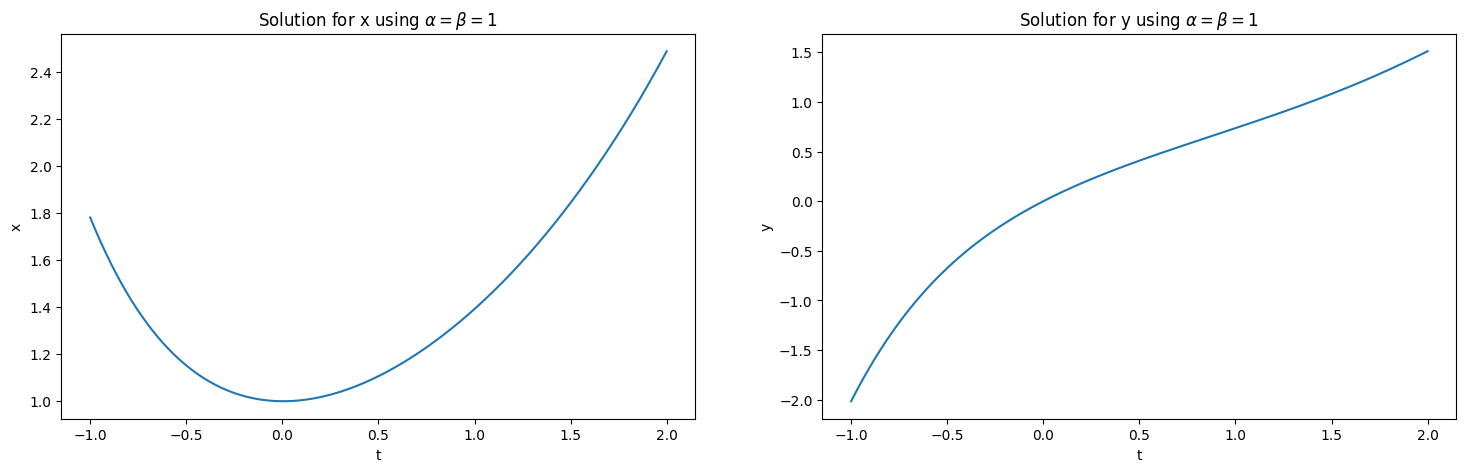

In [34]:
v_sol_ii = solver_ii.get_solution()
t_ii = np.linspace(t_0_ii, t_f_ii, 1000)
alpha = 1
alphas_ii = alpha * np.ones_like(t_ii)
beta = 1
betas_ii = beta * np.ones_like(t_ii)
x_ii, y_ii = v_sol_ii(t_ii, alphas_ii, betas_ii, to_numpy=True)


fig, ax = plt.subplots(1, 2, figsize=(18,5))
ax[0].plot(t_ii, x_ii)
ax[0].set_xlabel('t')
ax[0].set_ylabel('x')
ax[0].set_title(r'Solution for x using $\alpha = \beta = 1$')
ax[1].plot(t_ii, y_ii)
ax[1].set_xlabel('t')
ax[1].set_ylabel('y')
ax[1].set_title(r'Solution for y using $\alpha = \beta = 1$')
plt.show()

C:\Users\Usuario\AppData\Local\Temp\ipykernel_18224\2845622929.py:5: RuntimeWarning: invalid value encountered in divide
  perc_err_y_ii = 100 * np.abs(y_ii - y_exact)/np.abs(y_exact)


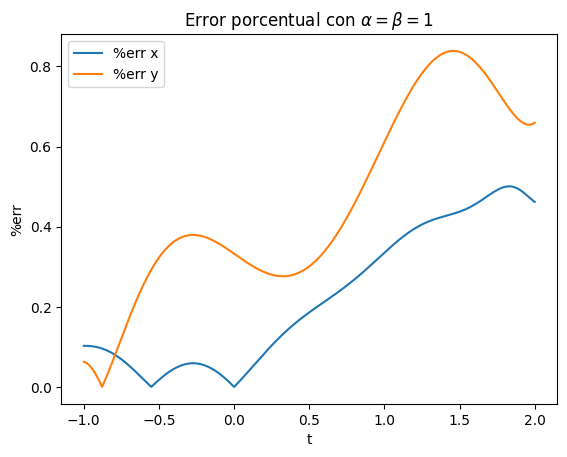

In [35]:
x_exact = sol_exacta(t_ii)
y_exact = sol_exacta_derivada(t_ii)

perc_err_x_ii = 100 * np.abs(x_ii - x_exact)/np.abs(x_exact)
perc_err_y_ii = 100 * np.abs(y_ii - y_exact)/np.abs(y_exact)

plt.figure()
plt.plot(t_ii, perc_err_x_ii, label = '%err x')
plt.plot(t_ii, perc_err_y_ii, label = '%err y')
plt.xlabel('t')
plt.ylabel('%err')
plt.title(r'Error porcentual con $\alpha = \beta= 1$')
plt.legend()
plt.show()

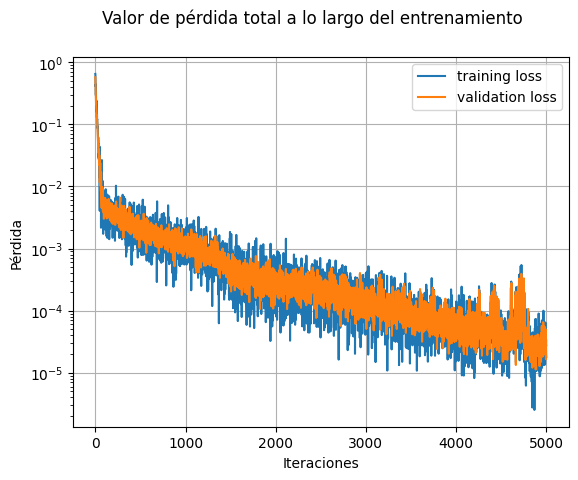

In [36]:
plt.figure()
perdida_train = solver.metrics_history['train_loss']
perdida_valid = solver.metrics_history['valid_loss']
plt.plot(perdida_train, label='training loss')
plt.plot(perdida_valid, label='validation loss')
plt.xlabel('Iteraciones')
plt.ylabel('Pérdida')
plt.yscale('log')
plt.grid()
plt.legend()
plt.suptitle('Valor de pérdida total a lo largo del entrenamiento')
plt.show()

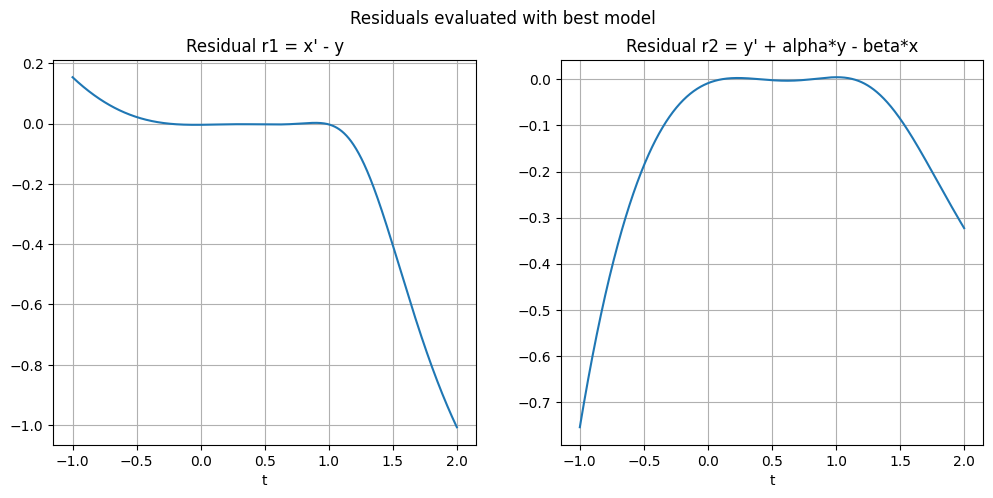

In [37]:
# Llamá a get_residuals con numpy arrays y que te devuelva numpy
residuals = solver.get_residuals(t_ii, alphas_ii, betas_ii, to_numpy=True)

# residuals es una lista con residuos para cada ecuación (r1 y r2)
r1_ii = residuals[0]
r2_ii = residuals[1]

# Graficar
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(t_ii, r1_ii)
plt.title('Residual r1 = x\' - y')
plt.xlabel('t')
plt.grid()

plt.subplot(1,2,2)
plt.plot(t_ii, r2_ii)
plt.title('Residual r2 = y\' + alpha*y - beta*x')
plt.xlabel('t')
plt.grid()

plt.suptitle('Residuals evaluated with best model')
plt.show()


Para el nuevo intervalo temporal suceden varias cosas. En primer lugar, el problema se vuelve más complejo debido a que la pendiente de x' cambia de signo al pasar por cero. Esto afectó claramente el rendimiento de la red: al mantener los parámetros anteriores (2 capas de 32 neuronas y un batch size de 5) no logré reducir el error de x' por debajo del 2% en la zona de cambio de positividad a negatividad. Para mejorar la precisión fue necesario hacer la red más profunda (3 capas: las dos primeras con 64 neuronas y la última con 32) y también más ancha. Además, aumenté el batch size (aprovechando que todavía tenía memoria disponible en la GPU) y el número de iteraciones a 6000.

Estos cambios hicieron que el entrenamiento fuese significativamente más lento, con una duración de aproximadamente 25 minutos. Sin embargo, logré mejorar la red y obtener errores inferiores al 1 % para todo el intervalo temporal, con una loss que decrece de forma consistente (sin indicios de overfitting). Finalmente, al analizar los residuos, observamos que este ajuste no fue tan favorable, ya que los residuos resultaron ser dos órdenes de magnitud mayores que antes.